# 1.2 How Autoencoders work

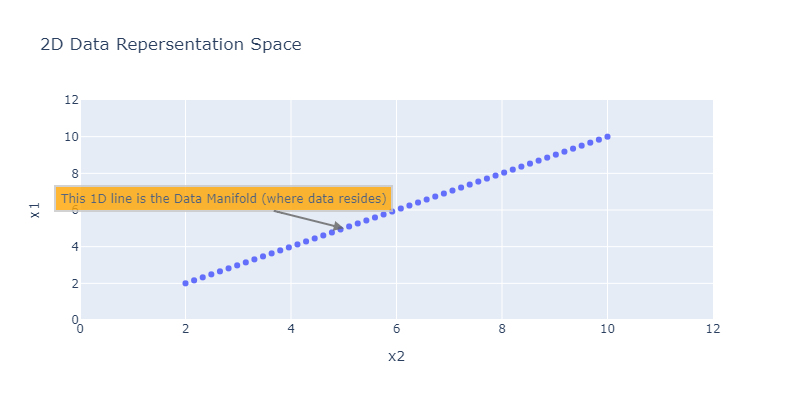

In [1]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import numpy as np
init_notebook_mode(connected=True)

## generate random data
N = 50
random_x=np.linspace(2,10, N)
random_y1 = np.linspace(2,10,N)
random_y2 = np.linspace(2,10,N)

trace1 = go.Scatter(x=random_x,y=random_y1,mode='markers',name='Actual Data')
trace2 = go.Scatter(x=random_x,y=random_y2,mode='lines',name='Model')
layout = go.Layout(title='2D Data Repersentation Space', xaxis=dict(title='x2', range=(0,12)),
                  yaxis=dict(title='x1',range=(0,12)), height=400, 
                   annotations=[dict(x=5,y=5,xref='x',yref='y',text='This 1D line is the Data Manifold (where data resides)',
                                    showarrow=True, align='center',arrowhead=2,arrowsize=1,arrowwidth=2,arrowcolor='#636363',
                                    ax=-120, ay=-30, bordercolor='#c7c7c7', borderwidth=2,borderpad=4, bgcolor='orange',opacity=0.8)])
figure = go.Figure(data=[trace1],layout=layout)
iplot(figure)

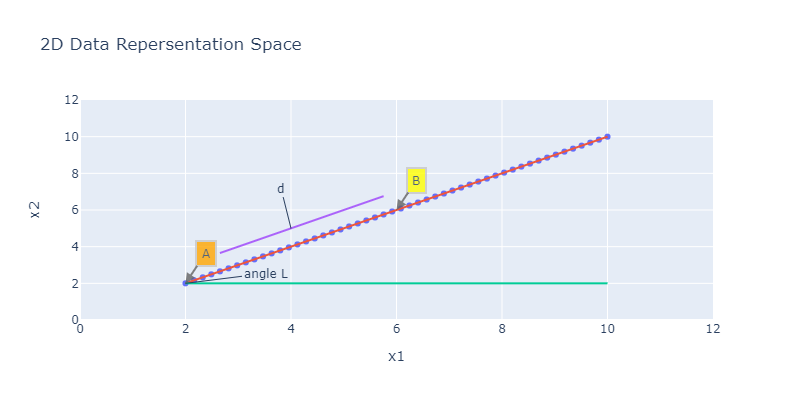

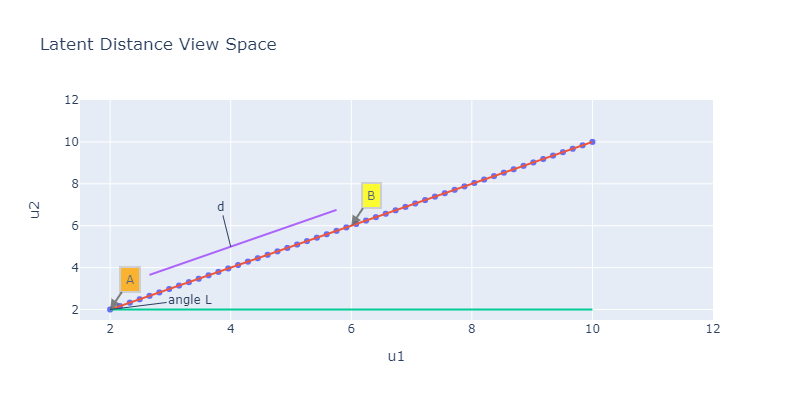

In [2]:
random_y3=[2 for i in range(100)]
random_y4=random_y2+1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="x1", range=(0,12)), yaxis=dict(title="x2", range=(0,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="2D Data Repersentation Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)



#################

random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="u1", range=(1.5,12)), yaxis=dict(title="u2", range=(1.5,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="Latent Distance View Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)

# Different Rules for Different data

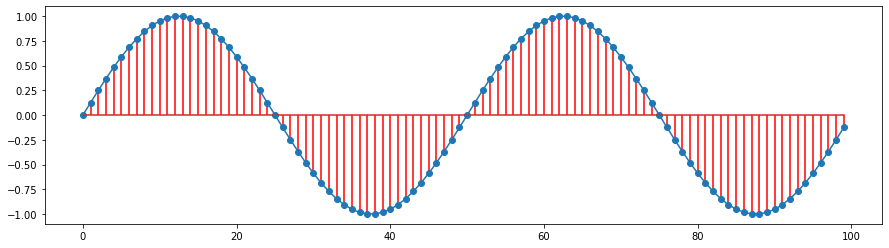

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fs = 100 # sample rate
f = 2 # the frequency of the signal
x = np.arange(fs) # the points on the x axis for plotting
y = [ np.sin(2*np.pi*f*(i/fs)) for i in x]

%matplotlib inline
plt.figure(figsize=(15,4))
plt.stem(x,y,'r',)
plt.plot(x,y)

# 2. Implementation

## 2.1 UseCase 1: Image Reconstruction

### 1. Load the required libraries

In [6]:
## load the libraries
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

## 2. Dataset Preparation

In [7]:
## read dataset
train = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

## reshape the inputs
train_x = train_x.reshape(-1,784)
val_x = val_x.reshape(-1,784)

## 3. Create Autoencoder architecture

In [10]:
## input layer
input_layer = Input(shape=(784,))

## endcoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)


## latent view
latent_view = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_10 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_12 (Dense)             (None, 500)               5500      
_________________________________________________________________
dense_13 (Dense)             (None, 1000)              501000

In [12]:
model.compile(optimizer='adam',loss='mse')
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1,mode='auto')
model.fit(train_x,train_x,epochs=20,batch_size=2048, validation_data=(val_x,val_x),callbacks=[early_stopping])

Epoch 1/20
24/24 [==============================] - 2s 38ms/step - loss: 0.1238 - val_loss: 0.0710
Epoch 2/20
24/24 [==============================] - 1s 24ms/step - loss: 0.0666 - val_loss: 0.0543
Epoch 3/20
24/24 [==============================] - 1s 25ms/step - loss: 0.0525 - val_loss: 0.0437
Epoch 4/20
24/24 [==============================] - 1s 28ms/step - loss: 0.0420 - val_loss: 0.0385
Epoch 5/20
24/24 [==============================] - 1s 26ms/step - loss: 0.0377 - val_loss: 0.0360
Epoch 6/20
24/24 [==============================] - 1s 25ms/step - loss: 0.0354 - val_loss: 0.0343
Epoch 7/20
24/24 [==============================] - 1s 24ms/step - loss: 0.0334 - val_loss: 0.0303
Epoch 8/20
24/24 [==============================] - 1s 24ms/step - loss: 0.0299 - val_loss: 0.0286
Epoch 9/20
24/24 [==============================] - 1s 23ms/step - loss: 0.0277 - val_loss: 0.0260
Epoch 10/20
24/24 [==============================] - 1s 24ms/step - loss: 0.0256 - val_loss: 0.0255
Epoch 11/

In [13]:
preds = model.predict(val_x)

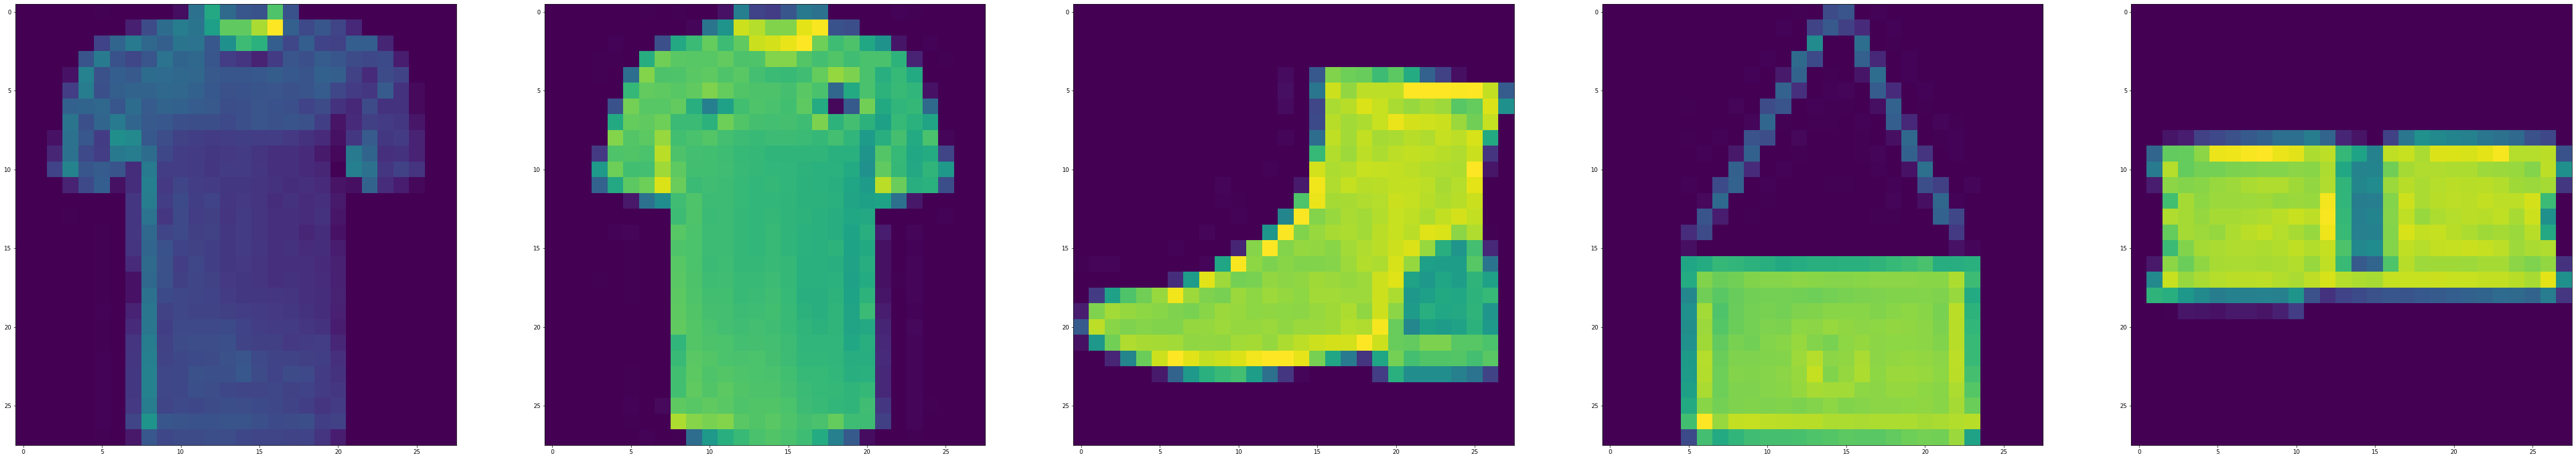

In [14]:
from PIL import Image
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28,28))
    
plt.show()

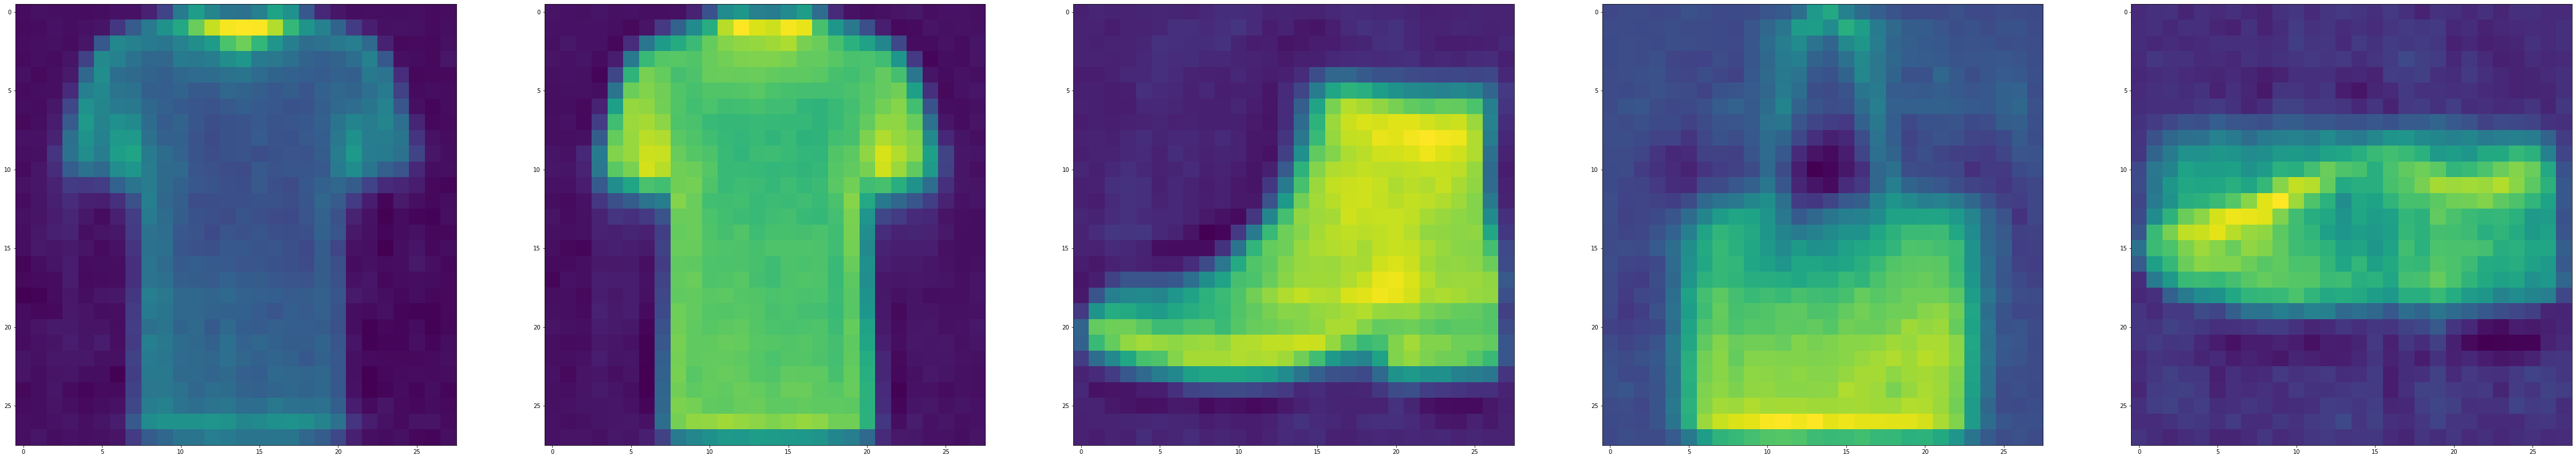

In [15]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28,28))

plt.show()

## 2.2 UseCase 2 - Image Denoising

In [16]:
## recreate the train_x array and val_x array
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x,test_size=0.2)

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

In [17]:
train_x = train_x.reshape(-1,28,28,1)
val_x = val_x.reshape(-1,28,28,1)

#### Noisy Images

In [18]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x*255)/255
val_x_n = seq_object.augment_images(val_x*255)/255

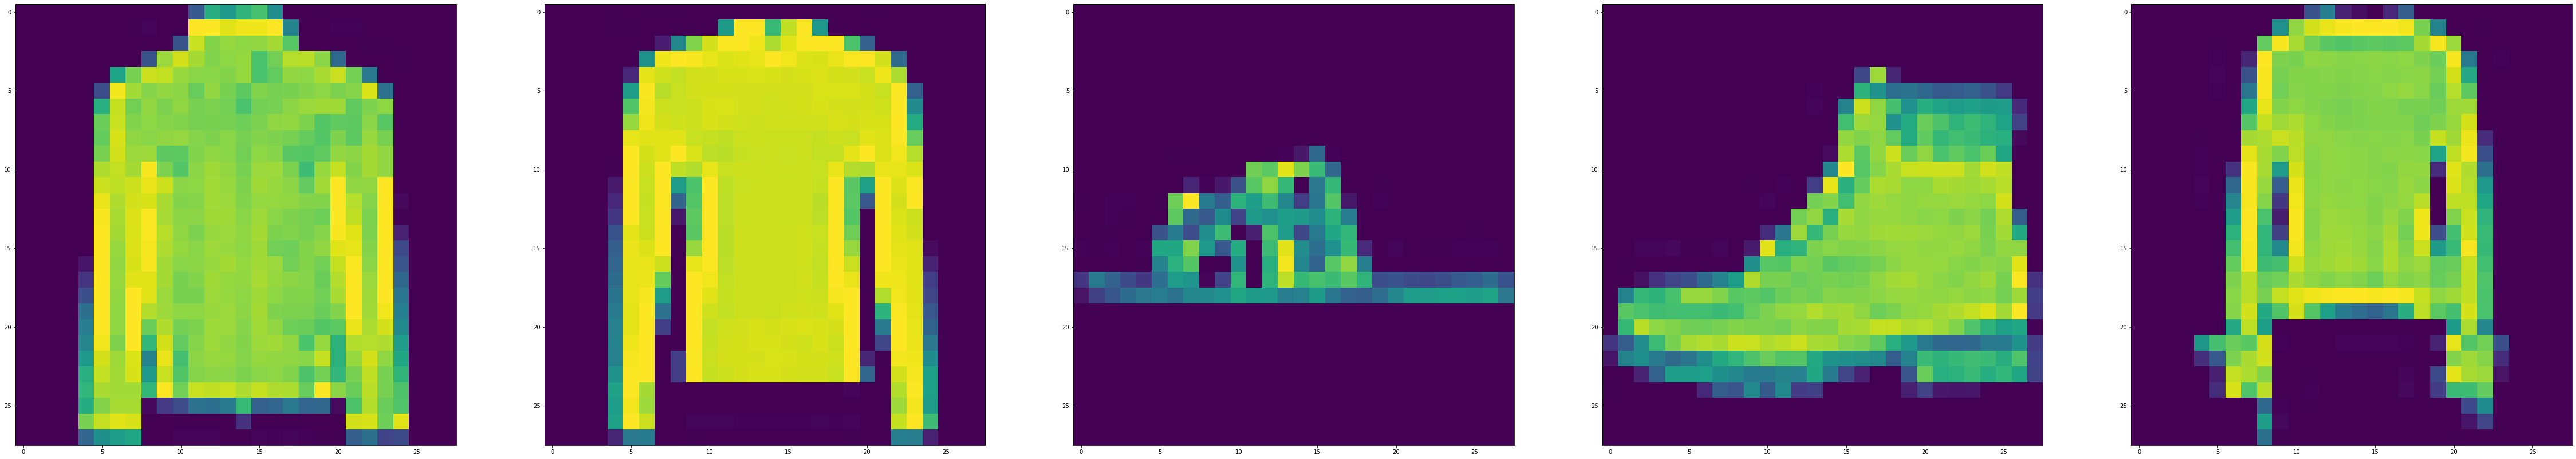

In [20]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28,28))
    
plt.show()

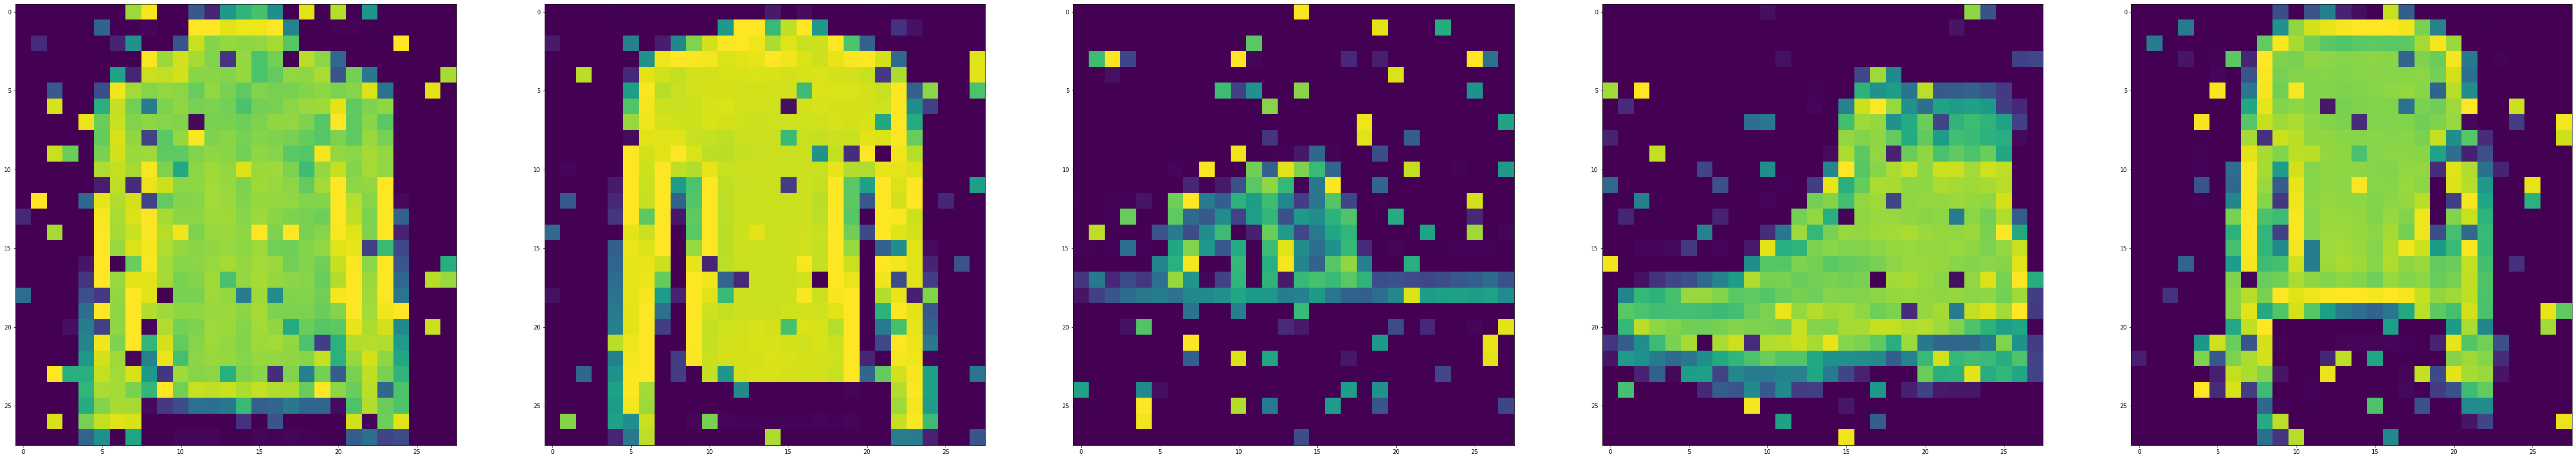

In [21]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80,40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28,28))
    
plt.show()

In [22]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [23]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0   

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/10
24/24 [==============================] - 6s 101ms/step - loss: 0.1286 - val_loss: 0.0567
Epoch 2/10
24/24 [==============================] - 2s 69ms/step - loss: 0.0511 - val_loss: 0.0381
Epoch 3/10
24/24 [==============================] - 2s 74ms/step - loss: 0.0360 - val_loss: 0.0320
Epoch 4/10
24/24 [==============================] - 2s 69ms/step - loss: 0.0309 - val_loss: 0.0282
Epoch 5/10
24/24 [==============================] - 2s 69ms/step - loss: 0.0276 - val_loss: 0.0258
Epoch 6/10
24/24 [==============================] - 2s 71ms/step - loss: 0.0253 - val_loss: 0.0242
Epoch 7/10
24/24 [==============================] - 2s 71ms/step - loss: 0.0237 - val_loss: 0.0228
Epoch 8/10
24/24 [==============================] - 2s 69ms/step - loss: 0.0226 - val_loss: 0.0219
Epoch 9/10
24/24 [==============================] - 2s 69ms/step - loss: 0.0218 - val_loss: 0.0213
Epoch 10/10
24/24 [==============================] - 2s 68ms/step - loss: 0.0211 - val_loss: 0.0205


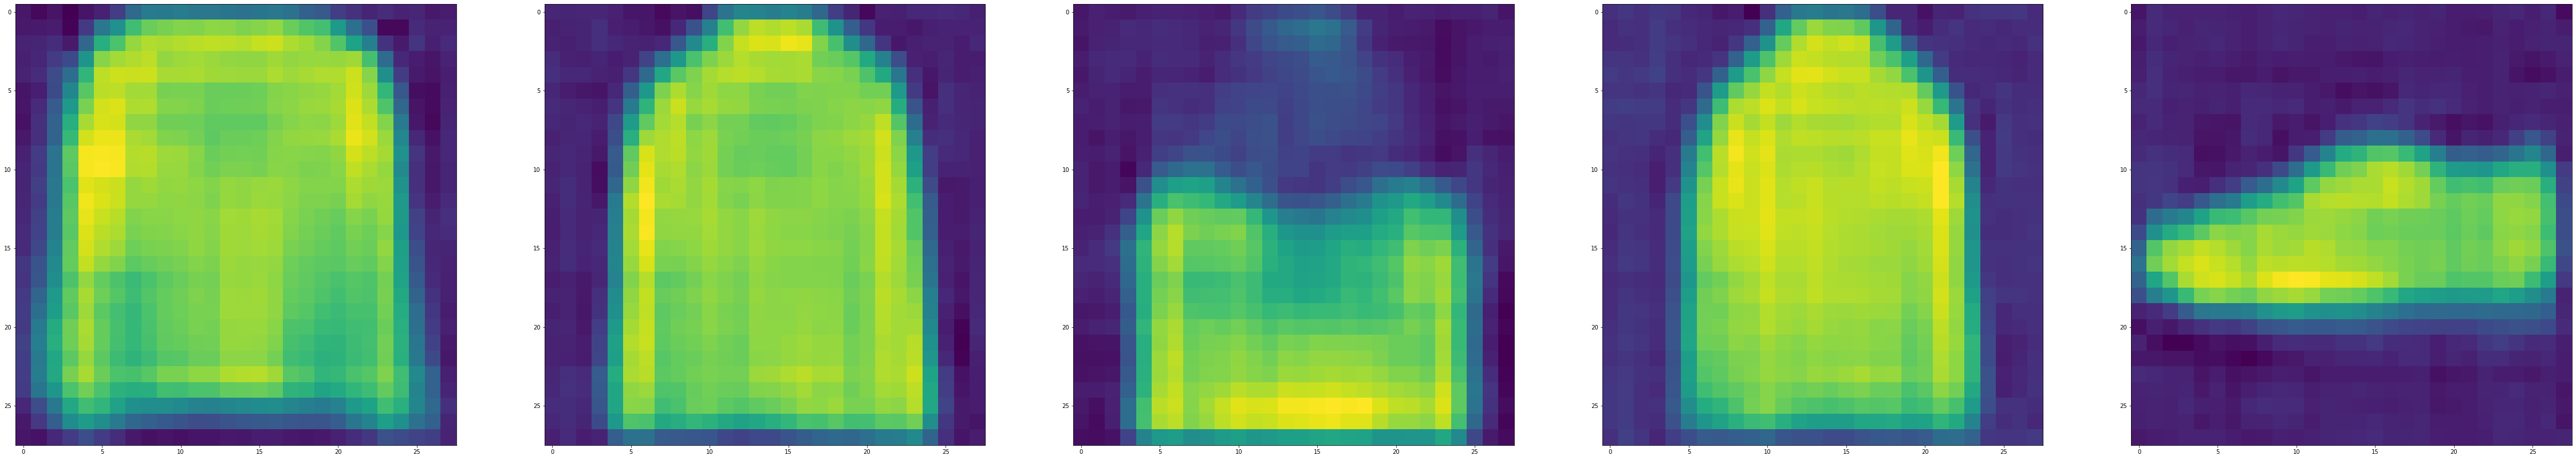

In [25]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()

## 2.3 UseCase 3 : Sequence to Sequence Prediction using AutoEncoders

####### Reference : https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

In [26]:
def dataset_preparation(n_in, n_out, n_unique, n_samples):
    X1, X2, y = [], [], []
    for _ in range(n_samples):
        ## create random numbers sequence - input 
        inp_seq = [randint(1, n_unique-1) for _ in range(n_in)]
        
        ## create target sequence
        target = inp_seq[:n_out]
    
        ## create padded sequence / seed sequence 
        target_seq = list(reversed(target))
        seed_seq = [0] + target_seq[:-1]  
        
        # convert the elements to categorical using keras api
        X1.append(to_categorical([inp_seq], num_classes=n_unique))
        X2.append(to_categorical([seed_seq], num_classes=n_unique))
        y.append(to_categorical([target_seq], num_classes=n_unique))
    
    # remove unnecessary dimention
    X1 = np.squeeze(np.array(X1), axis=1) 
    X2 = np.squeeze(np.array(X2), axis=1) 
    y  = np.squeeze(np.array(y), axis=1) 
    return X1, X2, y

samples = 100000
features = 51
inp_size = 6
out_size = 3

inputs, seeds, outputs = dataset_preparation(inp_size, out_size, features, samples)
print("Shapes: ", inputs.shape, seeds.shape, outputs.shape)
print ("Here is first categorically encoded input sequence looks like: ", )
inputs[0][0]

Shapes:  (100000, 6, 51) (100000, 3, 51) (100000, 3, 51)
Here is first categorically encoded input sequence looks like: 


array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [27]:
def define_models(n_input, n_output):
    ## define the encoder architecture 
    ## input : sequence 
    ## output : encoder states 
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    ## define the encoder-decoder architecture 
    ## input : a seed sequence 
    ## output : decoder states, decoded output 
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    ## define the decoder model
    ## input : current states + encoded sequence
    ## output : decoded sequence
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

autoencoder, encoder_model, decoder_model = define_models(features, features)

In [28]:
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 51)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 92160     
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


In [29]:
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  92160       input_6[0][0]                    
                                                                 input_7[0][0]              

In [30]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None, 51)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 92160       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  92160       input_6[0][0]                    
                                                                 lstm[0][1]                 

In [31]:
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
autoencoder.fit([inputs, seeds], outputs, epochs=1)

3125/3125 [==============================] - 20s 6ms/step - loss: 1.4515 - acc: 0.5516


In [32]:
def reverse_onehot(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

def predict_sequence(encoder, decoder, sequence):
    output = []
    target_seq = np.array([0.0 for _ in range(features)])
    target_seq = target_seq.reshape(1, 1, features)

    current_state = encoder.predict(sequence)
    for t in range(out_size):
        pred, h, c = decoder.predict([target_seq] + current_state)
        output.append(pred[0, 0, :])
        current_state = [h, c]
        target_seq = pred
    return np.array(output)

In [33]:
for k in range(5):
    X1, X2, y = dataset_preparation(inp_size, out_size, features, 1)
    target = predict_sequence(encoder_model, decoder_model, X1)
    print('\nInput Sequence=%s SeedSequence=%s, PredictedSequence=%s' 
          % (reverse_onehot(X1[0]), reverse_onehot(y[0]), reverse_onehot(target)))


Input Sequence=[34, 25, 41, 12, 31, 38] SeedSequence=[41, 25, 34], PredictedSequence=[41, 25, 34]

Input Sequence=[14, 38, 33, 31, 25, 24] SeedSequence=[33, 38, 14], PredictedSequence=[33, 38, 14]

Input Sequence=[40, 14, 43, 4, 13, 11] SeedSequence=[43, 14, 40], PredictedSequence=[43, 14, 40]

Input Sequence=[3, 10, 17, 24, 38, 14] SeedSequence=[17, 10, 3], PredictedSequence=[17, 10, 3]

Input Sequence=[6, 36, 47, 17, 14, 30] SeedSequence=[47, 36, 6], PredictedSequence=[47, 36, 6]
